### The Allen-Canh (1D case)
The Allen-cahn equation:
\begin{equation}
\begin{split}
    u_t - \lambda u_{xx} + 5u^3 - 5u &= 0 \quad \text{in}\ [0,T]\times[-1,1] \\
    u(0,x)   &= g(x)\quad   \text{in}\ [-1,1]\\
    u(t,-1) &= u(t,1)  \\
    u_x(t,-1) &= u_x(t,1)
\end{split}
\end{equation}
where $\lambda=0.0001$ and 
\begin{equation}
    g(x) = x^2 * cos(\pi * x)
\end{equation}

### (1) Prepare Data

dict_keys(['__header__', '__version__', '__globals__', 'tt', 'uu', 'x'])


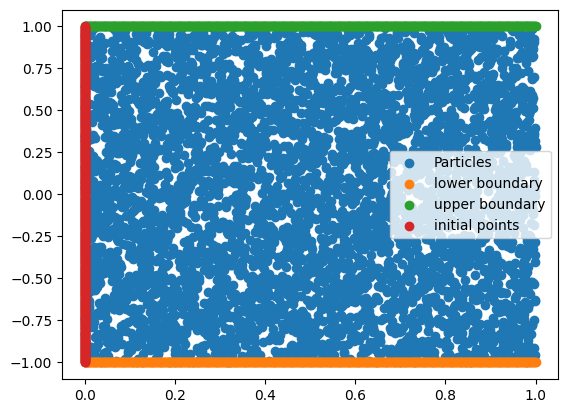

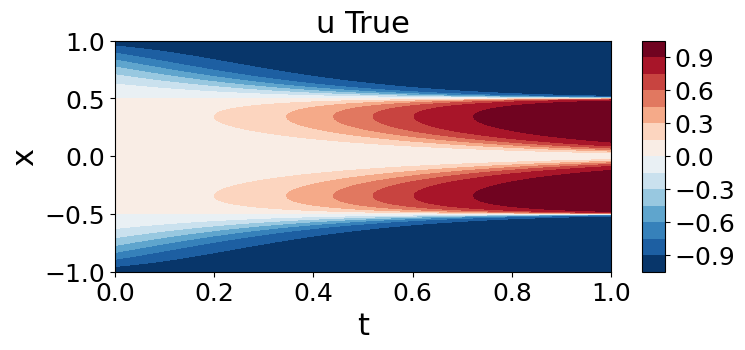

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import scipy.io
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Allen_Cahn'
######################################
# Load the problem (wave 1d)
######################################
from Utils.GenPoints_Time import Point1D
pointGen = Point1D(x_lb=[-1.], x_ub=[1.], dataType=dtype, random_seed=random_seed)
data_test = scipy.io.loadmat('../../Problems/Allen_Cahn/allen_cahn_1d.mat')
print(data_test.keys())
#
x_mesh, t_mesh = np.array(data_test['x'].T), np.array(data_test['tt'].T)
x_mesh, t_mesh = np.meshgrid(x_mesh, t_mesh)
xt_test = torch.tensor(np.vstack([x_mesh.flatten(), t_mesh.flatten()]).T, dtype=dtype)
u_test = torch.tensor(np.array(data_test['uu'].T).reshape(-1,1), dtype=dtype)
######################################
# Generate training data
######################################
Nx_center, Nt_center, N_init, N_bd = 1, 5000, 500, 500 
#### Particles (centers of CSRBFs)
xc_train, tc_train, R_train = pointGen.weight_centers(
    n_center=Nx_center, nt=Nt_center, Rmax=1e-4, Rmin=1e-4, method='hypercube')
#### (initial points)
xt_init = pointGen.init_point(num_sample=N_init, t_stamp=[0.], method='mesh')
#### (boundary points)
xt_lb, xt_ub = pointGen.boundary_point(num_sample=N_bd)
#########################################
plt.figure()
plt.scatter(tc_train[...,0], xc_train[...,0], label='Particles')
plt.scatter(xt_lb[:,-1], xt_lb[:,0], label='lower boundary')
plt.scatter(xt_ub[:,-1], xt_ub[:,0], label='upper boundary')
plt.scatter(xt_init[:,-1], xt_init[:,0], label='initial points')
plt.legend()
plt.show()
#######
from Utils.PlotFigure import Plot
Plot.show_1dt(xt_test, u_test, title='u True', tT=1.)

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=1, n_mesh_or_grid=25, 
    dataType=dtype).get_testFun()

#################################
def f_init(xt_device):
    x = xt_device[...,0:1]
    return x**2 * torch.cos(torch.pi * x)

##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']
        ######################## 
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = phi.to(self.device)
        self.dv_dr = dphi_dr.to(self.device)
        #
        self.solver.getLoss = torch.nn.MSELoss()
        
    def Loss_pde(self, xc=None, tc=None, R=None, lamda=0.0001):
        '''Define the PDE loss
        '''
        xc, tc, R = xc_train.to(self.device), tc_train.to(self.device), R_train.to(self.device)
        ################################## 
        nc = xc.shape[0]
        x = self.int_grid * R + xc
        t = tc.repeat(1, self.n_grid, 1)
        x = Variable(x.reshape(-1, 1), requires_grad=True)
        t = Variable(t.reshape(-1, 1), requires_grad=True)
        xt = torch.cat([x,t], dim=-1)
        ##########################################
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 1)
        ##########################################
        u = self.model_u(xt)
        du = self.solver.grad(u, [x, t])
        dux, dut = du[0], du[1]
        ########################################### weawk form
        res1 = (dut*v + 5. * (u**3 - u)*v 
                + lamda * torch.sum( dux * dv, dim=1, keepdims=True) )
        res1 = torch.mean(res1.reshape(nc, self.n_grid), dim=-1, keepdim=True)
        ###########################################
        loss = self.solver.getLoss(res1, torch.zeros_like(res1))
        
        return loss * 100.

    def Loss_bd(self):
        ''' '''
        ############### The initial condition
        xt = Variable(xt_init, requires_grad=True).to(self.device)
        u_init, u_init_ = self.model_u(xt), f_init(xt)
        #
        loss_init = self.solver.getLoss(u_init, u_init_)
        ############### The boundary condition
        ### The upper
        xtub = Variable(xt_ub, requires_grad=True).to(self.device)
        u_ub = self.model_u(xtub)
        du_ub = self.solver.grad(u_ub, [xtub])[0][...,0:1]
        ### The lower 
        xtlb = Variable(xt_lb, requires_grad=True).to(self.device)
        u_lb = self.model_u(xtlb)
        du_lb = self.solver.grad(u_lb, [xtlb])[0][...,0:1]
        #
        loss_bd = (self.solver.getLoss(u_ub, u_lb) 
                   + self.solver.getLoss(du_lb, du_ub))
        
        return (50*loss_init + 5.*loss_bd)
        
    def Error(self):
        ''' '''
        xt = xt_test.to(self.solver.device)
        u = u_test.to(self.solver.device)
        ####### 
        u_pred = self.model_u(xt)
        error = self.solver.getError(u_pred, u)

        return error

##########################################
from Solvers.ParticleWNN import ParticleWNN_Time
#
solver = ParticleWNN_Time.Solver(device, dtype=dtype)
model_u = solver.getModel([2, 40, 40, 40, 40, 1], 'Tanh_Sin', netType='FCNet')

### (3) Training and predicting

#### (3.1) Train the model

In [ ]:
model_dict = {'u': model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', step_size=4000, lbfgs=True, max_iter=1000)
solver.train(LossClass, xc_train, tc_train, R_train, batch_size_in=int(np.ceil(xc_train.shape[0]/10)), 
             w_pde=100, w_bd=50., epochs=20000, **{'save_path':f'saved_models/'})
solver.train_lbfgs(LossClass, xc_train, tc_train, R_train, epochs=200, 
                   w_pde=100, w_bd=50, **{'save_path':f'saved_models/'})

#### (3.2) Make prediction

The l2_err is tensor([0.0145])


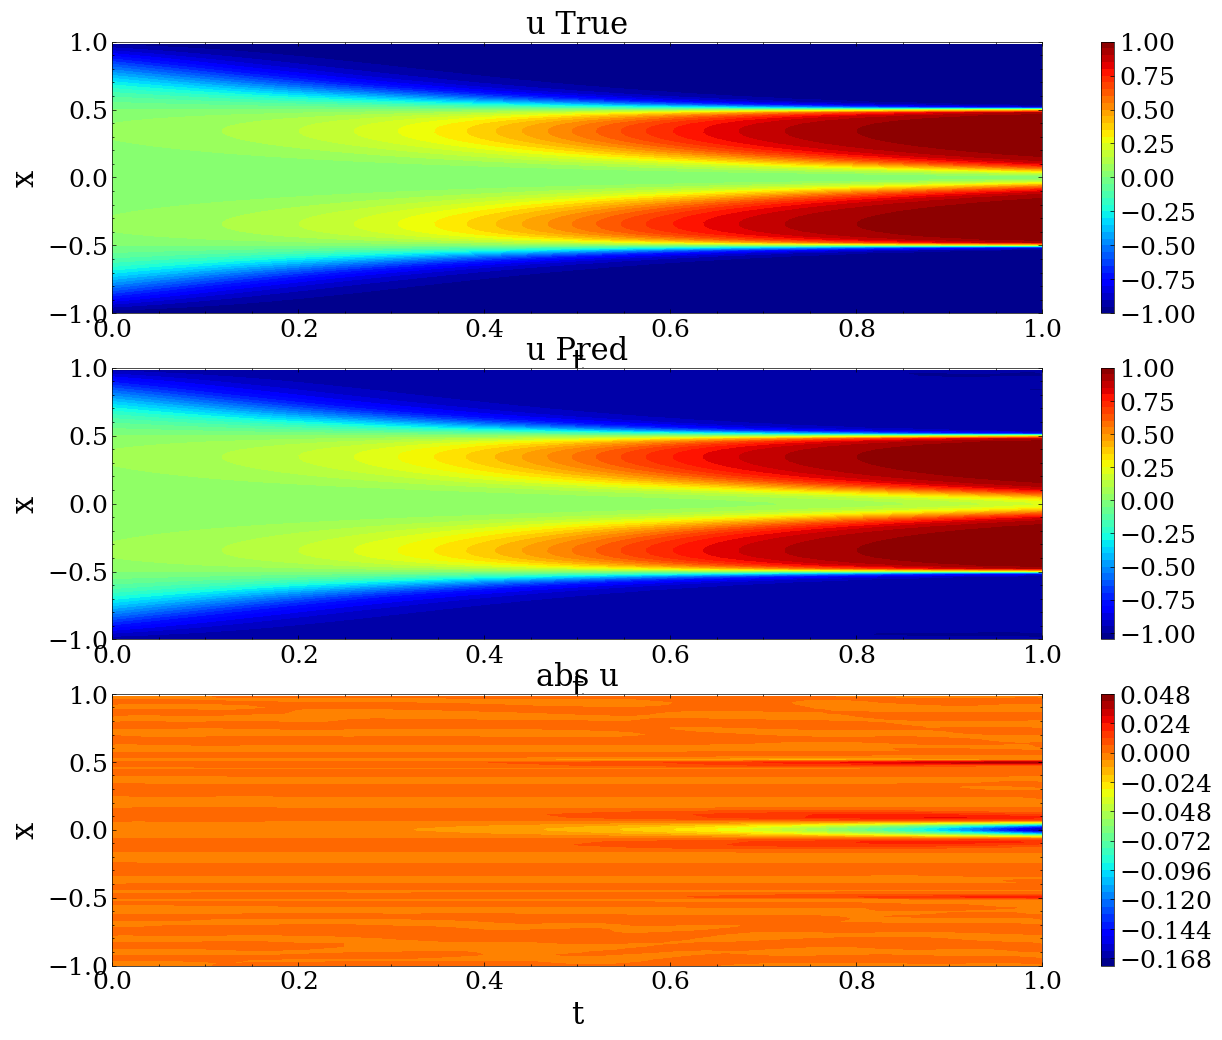

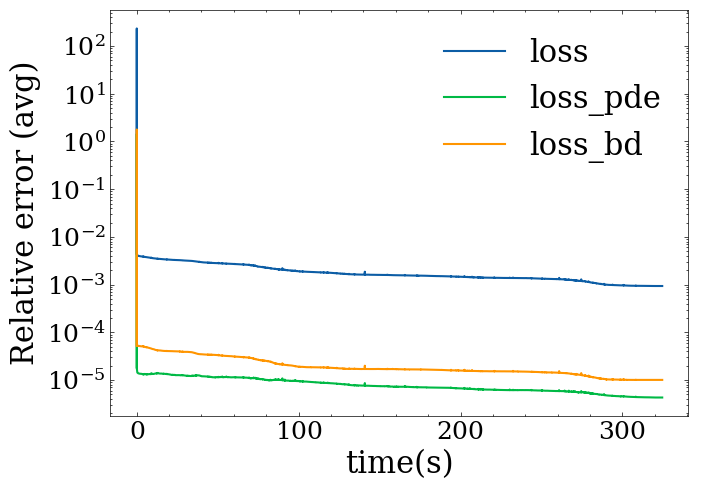

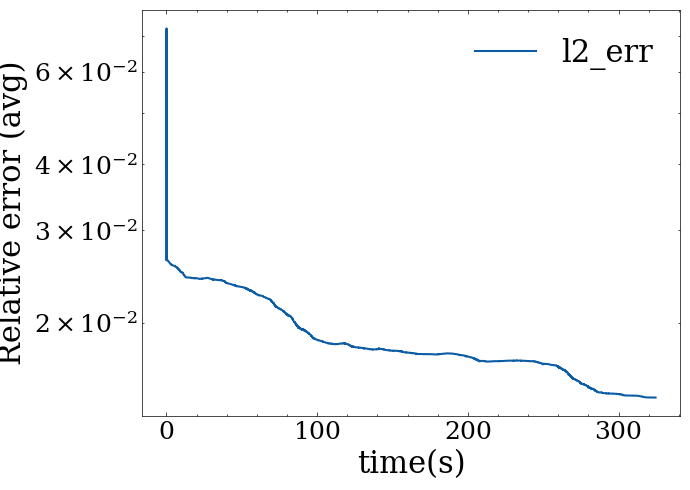

In [3]:
from torch.autograd import grad, Variable
from Utils.PlotFigure import Plot
from Solvers.ParticleWNN import ParticleWNN_Time
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model 
###############################
solver = ParticleWNN_Time.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_particlewnn_final')

###############################
# make prediction
###############################
xt_var = Variable(xt_test, requires_grad=True).to(device)
u_var = model_trained['u'](xt_var)
u_var = u_var.detach().cpu()
print('The l2_err is', myerror(u_var, u_test))

###############################
# show the result
###############################
Plot.show_1dt_list(xt_test, [u_test, u_var, u_test-u_var], ['u True', 'u Pred', 'abs u'])
##### show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_particlewnn')
Plot.show_error([loss_saved['time']]*3, 
                [loss_saved['loss'], loss_saved['loss_pde'], loss_saved['loss_bd']],
                ['loss', 'loss_pde', 'loss_bd'])
##### show the error
Plot.show_error([loss_saved['time']], [loss_saved['error']], ['l2_err'])